In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.gridspec as gridspec


#### Some global definitions


In [2]:
c = 1 

# Global options
np.random.seed(11)
do_debug = False
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Make plots from each agent reference frame
change_reference = True

# Model parameters
num_agents = 4 
dim        = 3 # Number of spatial dimensions
num_steps  = 100
step_size  = 0.1 

# Parameters for consensus
consensus_kc = 1e-1
consensus_kv = 1 


#### Generate array of positions

The dimensions of the array is num_agents x num_steps x dim+1. So pos[0] will contain the 4-position of particle 0, with one row per time step. We generate position 0 randomly, and then iterate it with a random v0. We normalize each initial 3-velocity to 0.9 times the speed of light.

In [3]:
# Generate arrays and data
pos = np.zeros((num_agents, num_steps, dim+1))   # agent, step, (t, x, y, ...)

# Random initial positions and velocities:
a = -1
b = +1
pos[:,0,1:dim+1] = (b - a) * np.random.random((num_agents, dim)) + a 
# Generate initial velocity normalized to 1
v00 = np.random.normal(0, 0.5, (num_agents, dim))
v0 = v00/np.linalg.norm(v00, axis=1, keepdims=True)*c*0.9
# Update first time step based on initial velocity
pos[:,1,1:dim+1] = pos[:,0,1:dim+1] + v0*step_size
pos[:,1,0] = c*step_size

for j in range(num_agents):
    print('Agent {}'.format(j))
    print('v0 particle {0}:\n{1}'.format(j, v0[j]))
    print('position (t,x,y,z) of particle {0} over the first three time steps:\n{1}\n'.format(j, pos[j,0:3]))


Agent 0
v0 particle 0:
[ 0.2616086  -0.6620839  -0.55064131]
position (t,x,y,z) of particle 0 over the first three time steps:
[[ 0.         -0.63946062 -0.96104952 -0.07356295]
 [ 0.1        -0.61329976 -1.02725791 -0.12862708]
 [ 0.          0.          0.          0.        ]]

Agent 1
v0 particle 1:
[-0.42458309  0.61552834  0.50085334]
position (t,x,y,z) of particle 1 over the first three time steps:
[[ 0.          0.44986786 -0.15959279 -0.0291458 ]
 [ 0.1         0.40740955 -0.09803996  0.02093953]
 [ 0.          0.          0.          0.        ]]

Agent 2
v0 particle 2:
[-0.62800571 -0.53849922  0.3544396 ]
position (t,x,y,z) of particle 2 over the first three time steps:
[[ 0.         -0.97443837 -0.02525679  0.8836133 ]
 [ 0.1        -1.03723894 -0.07910671  0.91905726]
 [ 0.          0.          0.          0.        ]]

Agent 3
v0 particle 3:
[ 0.82545327 -0.01629016 -0.35827578]
position (t,x,y,z) of particle 3 over the first three time steps:
[[ 0.          0.70159018  

#### Functions to accelarate particles 

In [4]:
def calc_acc(j, step, pos, consensus_kc, consensus_kv):
    acc0 = np.sum(pos[j, step-1:step, 1:dim+1] - pos[:, step-1:step, 1:dim+1], axis=0)
    vel = np.diff(pos[:,step-2:step,1:dim+1], axis=1)/np.diff(pos[:,step-2:step,0:1], axis=1)
    acc = -consensus_kc*acc0 - consensus_kv*vel[j]
    #acc *= 0.1
    new_vel = vel[j] + acc*step_size
    delta_pos = new_vel*step_size
    return delta_pos

In [5]:
def make_plot(pos, vel, outfile='test1.png'):
    times = pos[0,:,0]  # fixed time frame
    # Compute distance from converging point and speed arrays
    final_pos = np.average(pos[:,-1,1:dim+1], axis=(0))
    dista = np.linalg.norm(pos[:,:,1:dim+1] - final_pos, axis=(2)) # size = num_agents x num_steps
    speed = np.linalg.norm(vel[:,:,:], axis=(2)) # size = num_agents x num_steps

    # Plot variables
    fig = plt.figure(figsize=(16,24))
    gs = gridspec.GridSpec(6, 2)
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    ax2a = fig.add_subplot(gs[2, 0])
    ax2b = fig.add_subplot(gs[2, 1])
    ax3a = fig.add_subplot(gs[3, 0])
    ax3b = fig.add_subplot(gs[3, 1])
    ax4a = fig.add_subplot(gs[4, 0])
    ax4b = fig.add_subplot(gs[4, 1])
    ax5a = fig.add_subplot(gs[5, 0])
    ax5b = fig.add_subplot(gs[5, 1])

    for j in range(num_agents):
        ax1.plot(pos[j,:,1], pos[j,:,2], marker='.', ls='-',  color=colors[j])
        #ax1.scatter(pos[j,:,1], pos[j,:,2], marker='.',  s = pos[j,:,3]*500, c=colors[j])
        ax2a.plot(times, pos[j,:,1], marker='.', ls='-',  color=colors[j])
        ax2b.plot(times, pos[j,:,2], marker='.', ls='-',  color=colors[j])
        ax3a.plot(times[:-1], vel[j,:,0], marker='.', ls='-',  color=colors[j])
        ax3b.plot(times[:-1], vel[j,:,1], marker='.', ls='-',  color=colors[j])
        ax4a.plot(times[:-1], speed[j], marker='', ls='-',  color=colors[j])
        ax4b.plot(times[:], dista[j], marker='', ls='-',  color=colors[j])
        ax5a.plot(times[:-1], gamma[j], marker='', ls='-',  color=colors[j])
        ax5b.plot(times[:-1], delta_tau[j]/step_size, marker='', ls='-',  color=colors[j])

    # Plot average speed and distance
    ax4a.plot(times[:-1], np.average(speed[:,:], axis=0), marker='', ls='-',
              lw=3, color='k', label='average speed')
    ax4b.plot(times[:], np.average(dista[:,:], axis=0), marker='', ls='-',
              lw=3, color='k', label='average distance')
    ax4a.legend(loc=0)
    ax4b.legend(loc=0)

    # Labels etc
    ax1.set_title('X-Y')
    ax2a.set_title('X vs time')
    ax2b.set_title('Y vs time')
    ax3a.set_title('Vx vs time')
    ax3b.set_title('Vy vs time')
    ax4a.set_title('|v| vs time')
    ax4b.set_title('Distance vs time')
    ax5a.set_title('gamma vs time')
    ax5b.set_title('delta_tau/delta_t vs time')
    ax1.set_aspect('equal')
    ax4a.semilogy()
    ax4b.semilogy()
    #ax1.set_xlim(-2,2)
    #ax1.set_ylim(-2,2)

    fig.savefig(outfile, bbox_inches='tight')


#### Functions regarding kinematics and Lorentz transformation

In [6]:
def calc_kinematics(pos):
    # From (t,x,y,z) per agent and time compute:
    # vel : 3-velocity  agent, step, (vx,vy, ...)
    # v   : speed       agent, step, ||v||
    # g   : gamma       agent, step, gamma
    # u   : 4-velocity  agent, step, (u0, ux, uy, ...)
    # tau : proper time agent, step, delta_t^2 - delta_x^2
    vel = np.diff(pos[:,:,1:dim+1], axis=1)/np.diff(pos[:,:,0:1], axis=1)
    v = np.linalg.norm(vel, axis=2)
    gamma = 1.0/np.sqrt(1-(v/c)**2)
    u   = np.zeros((pos.shape[0], pos.shape[1]-1, pos.shape[2])) # agent, step, (u0, ux, uy, ...)
    u[:,:, 1:dim+1] = gamma[:,:,np.newaxis]*vel
    u[:,:, 0] = gamma
    delta_t2 = np.diff(pos[:,:,0], axis=1)**2
    delta_x2 = (np.diff(pos[:,:,1:dim+1], axis=1)**2).sum(axis=2)
    delta_tau = np.sqrt(delta_t2 - delta_x2)
    return vel, v, gamma, u, delta_tau


def lorentz_transformation_global(pos):
    # Following page 6 from
    # http://www.physics.umanitoba.ca/~tosborn/EM_7590_Web_Page/Resource%20Materials/Lorentz%20transformation.pdf
    vel = np.diff(pos[:,:,1:dim+1], axis=1)/np.diff(pos[:,:,0:1], axis=1)
    I = np.eye(dim)[np.newaxis, np.newaxis, :]
    beta  = vel[:,:,:,np.newaxis]/c
    betaT = vel[:,:,np.newaxis,:]/c
    beta2 = np.sum(beta**2, axis=(2), keepdims=True)
    gamma = 1./np.sqrt(1-(beta2)**2)
    trans_space = I+(gamma-1)*beta*betaT/beta2

    lorentz = np.zeros((vel.shape[0], vel.shape[1], dim+1, dim+1))
    lorentz[:,:,0,0] = gamma[:,:,0,0]
    lorentz[:,:,0,1:] = -(gamma*betaT)[0,0,0,:]
    lorentz[:,:,1:,0] = -(gamma*beta)[0,0,:,0]
    lorentz[:,:,1:,1:] = trans_space
    return lorentz

def lorentz_transformation(vel_i):
    I = np.eye(dim)
    beta  = vel_i[:,np.newaxis]/c
    betaT = vel_i[np.newaxis,:]/c
    beta2 = np.sum(beta**2, keepdims=True)
    gamma = 1./np.sqrt(1-(beta2)**2)
    trans_space = I+(gamma-1)*beta*betaT/beta2

    lorentz = np.zeros((dim+1, dim+1))
    lorentz[0,0] = gamma[0,0]
    lorentz[0,1:] = -(gamma*betaT)[0,:]
    lorentz[1:,0] = -(gamma*beta)[:,0]
    lorentz[1:,1:] = trans_space
    return lorentz


#### Compute positions over time

position (t,x,y,z) of particle 1 over the first time steps:
[[ 0.          0.44986786 -0.15959279 -0.0291458 ]
 [ 0.1         0.40740955 -0.09803996  0.02093953]
 [ 0.2         0.36394121 -0.04009568  0.06838448]
 [ 0.3         0.31977906  0.0139871   0.11302876]
 [ 0.4         0.27522743  0.06399557  0.15473727]]



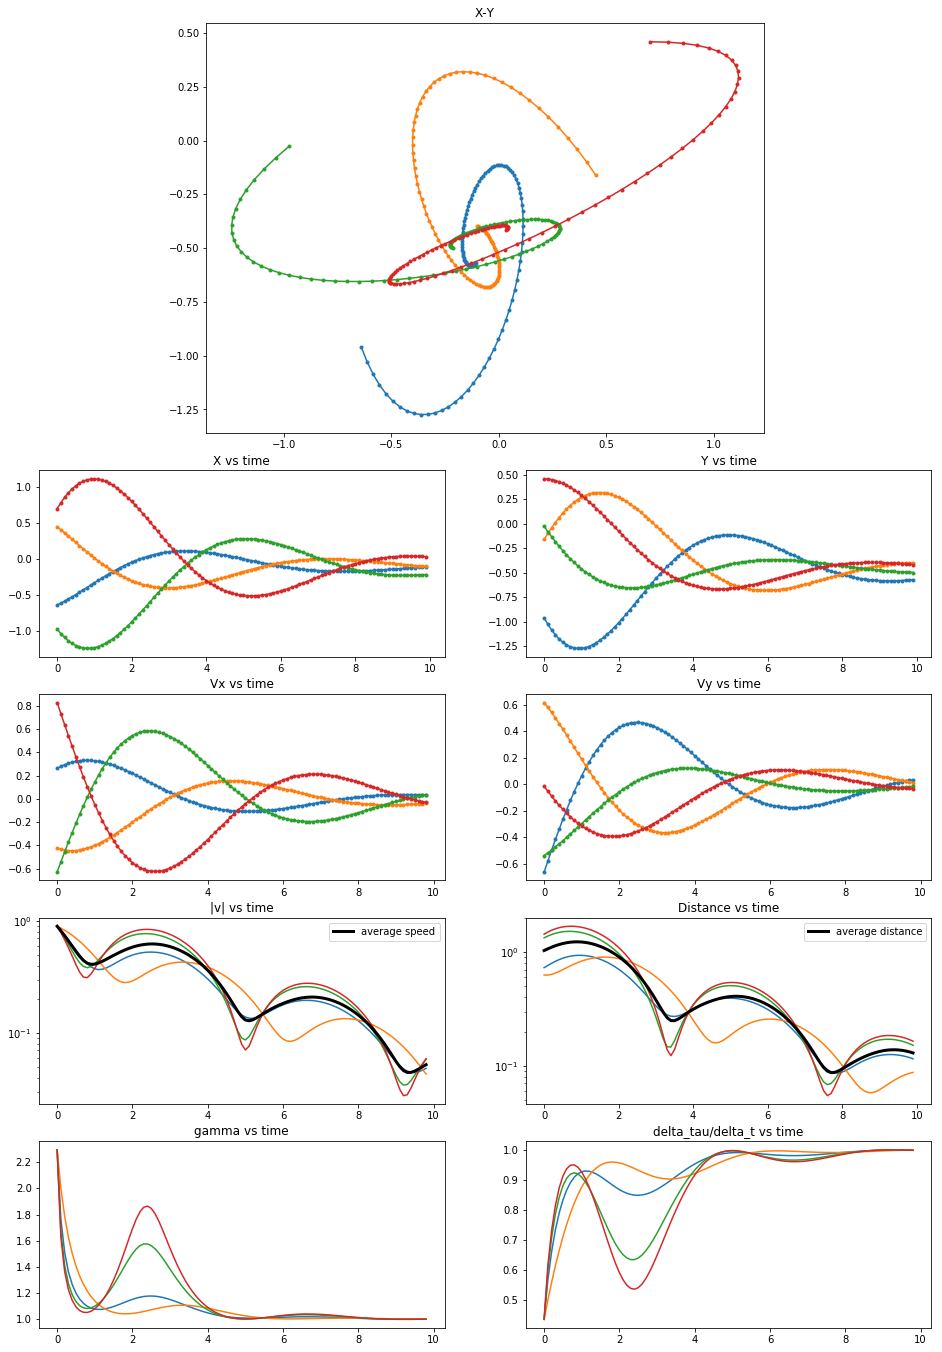

In [7]:
consensus_kc = 1.5e-1
consensus_kv = 0.5

# Generate evolution for each time step (s) for each agent (j)
for step in range(2, num_steps):
    for j in range(num_agents):
        delta_pos = calc_acc(j, step, pos, consensus_kc, consensus_kv)
        pos[j, step, 1:dim+1] = pos[j, step-1, 1:dim+1] + delta_pos
        pos[j, step, 0] = pos[j, step-1, 0] + c*step_size

j = 1
print('position (t,x,y,z) of particle {0} over the first time steps:\n{1}\n'.format(j, pos[j,0:5]))

vel, v, gamma, u, delta_tau = calc_kinematics(pos)

if False:
    plt.figure()
    plt.title('|v|')
    for j in range(num_agents):
        plt.plot(v[j])
    
    plt.figure()
    plt.title('gamma')
    for j in range(num_agents):
        plt.plot(np.log10(gamma[j]))
        
    plt.figure()
    plt.title('delta_tau')
    for j in range(num_agents):
        plt.plot(delta_tau[j])
        
make_plot(pos, vel, outfile = 'plot_ref.png')


#### Plots